In [ ]:
import os

os.chdir("/home/sambray/Documents/MS_analysis_samsplaying")

from Style.style_guide import animal_style
from Analysis.utils import filter_opto_data
from spyglass.lfp.analysis.v1 import LFPBandV1


from ms_opto_stim_protocol import OptoStimProtocol
import numpy as np
import matplotlib.pyplot as plt

from Analysis.lfp_analysis import get_ref_electrode_index
from spyglass.common import get_electrode_indices


def circular_statistics(theta):
    X = np.mean(np.cos(theta))
    Y = np.mean(np.sin(theta))
    r = (X**2 + Y**2) ** 0.5
    theta_avg = np.arctan2(Y, X)
    return r, theta_avg

[2025-05-29 11:46:23,039][INFO]: Connecting sambray@lmf-db.cin.ucsf.edu:3306
[2025-05-29 11:46:23,083][INFO]: Connected sambray@lmf-db.cin.ucsf.edu:3306
[11:46:29][INFO] Spyglass: Initializing UserEnvironment for spikesorting: sambray_base_00


In [ ]:
animal = "transfected"
animal = "control"
animal = "Yoshi"
animal = "Bilbo"
animal = "Olive"

key = {
    "animal": animal,
    "targeted_phase": 90,
    "min_pulse_length": 20,
    "track_type": "lineartrack",
}

dataset = filter_opto_data(key)

pulse_phase = []
for nwb_file_name, interval_list_name in zip(
    *dataset.fetch("nwb_file_name", "interval_list_name")
):

    lfp_key = {
        "nwb_file_name": nwb_file_name,
        "target_interval_list_name": interval_list_name,
        "filter_name": "Theta 5-11 Hz",
    }

    basic_key = {
        "nwb_file_name": nwb_file_name,
        "target_interval_list_name": interval_list_name,
    }
    ref_elect, basic_key = get_ref_electrode_index(basic_key)  #
    # ref_elect = (Electrode() & basic_key).fetch("original_reference_electrode")[0]
    if not len(band_query := (LFPBandV1 & lfp_key)):
        print(f"No LFP band found for {nwb_file_name} {interval_list_name}")
        continue
    lfp_eseries = (band_query).fetch_nwb()[0]["lfp_band"]
    ref_index = get_electrode_indices(lfp_eseries, [ref_elect])
    ref_index = ref_elect
    try:
        phase_df = (LFPBandV1() & lfp_key).compute_signal_phase([ref_index])
    except Exception as e:
        print(f"Failed to compute phase for {lfp_key}")
        raise e
        continue

    opto_key = {
        "nwb_file_name": nwb_file_name,
        "interval_list_name": interval_list_name,
    }

    stim_val, stim_time = OptoStimProtocol().get_stimulus(opto_key)

    stim = stim_time[stim_val == 1]

    stim_ind = np.digitize(stim, phase_df.index)

    pulse_phase.extend(phase_df.values[stim_ind])
    # break

datasets: 2


[2025-05-29 13:03:29,682][WARNING]: Skipped checksum for file with hash: eaf52893-1419-fe04-2ba5-a2b8ea80f655, and path: /stelmo/nwb/raw/Olive20220707_.nwb
[2025-05-29 13:03:32,111][WARNING]: Skipped checksum for file with hash: eaf52893-1419-fe04-2ba5-a2b8ea80f655, and path: /stelmo/nwb/raw/Olive20220707_.nwb


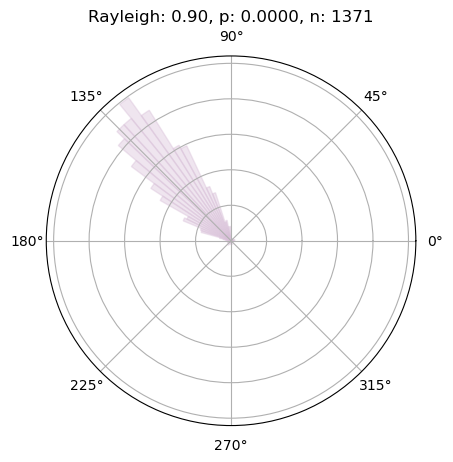

In [65]:
from scipy import stats

fig = plt.figure()
ax = fig.add_subplot(111, polar=True)

color = animal_style.loc[animal]["color"]
color = "thistle"

freq, theta = np.histogram(pulse_phase, bins=100)
freq = freq / freq.sum()
theta = (theta[1:] + theta[:-1]) / 2
width = np.radians(360 / len(theta))
ax.bar(
    theta,
    freq,
    width=width,
    facecolor=color,
    edgecolor=color,
    alpha=0.4,
    align="edge",
)
ax.set_yticklabels([])
# ax.set_xticklabels([0,"",90,"",180,"",270])

plt.rcParams["svg.fonttype"] = "none"
raleigh, theta_avg = circular_statistics(pulse_phase)

z = raleigh**2 * len(pulse_phase)
p = stats.norm.sf(z)

plt.title(f"Rayleigh: {raleigh:.2f}, p: {p:.4f}, n: {len(pulse_phase)}")

plt.Arrow(0, 0, 0.5, 0.5)
# plt.savefig(
#     "/home/sambray/Documents/MS_analysis_samsplaying/Figures_20250210/lineartrack_theta90_phase_histogram.svg"
# )

In [19]:
len(pulse_phase)

9275

In [ ]:
import scipy.stats as stats

raleigh, theta_avg = circular_statistics(pulse_phase)

z = raleigh**2 * len(pulse_phase)
p = stats.norm.sf(z)
np.exp(-z)

0.0

In [43]:
(LFPBandV1 & lfp_key).fetch_nwb()[0]

{'lfp_merge_id': UUID('b971c2bb-e7bf-aee6-59b6-801e2fc9bdae'),
 'filter_name': 'Theta 5-11 Hz',
 'filter_sampling_rate': 1000,
 'nwb_file_name': 'Winnie20220717_.nwb',
 'target_interval_list_name': 'pos 3 valid times',
 'lfp_band_sampling_rate': 100,
 'analysis_file_name': 'Winnie20220717_1XGGK7ESGM.nwb',
 'interval_list_name': 'pos 3 valid times lfp band 100Hz',
 'lfp_band_object_id': '973d3d96-d37b-434e-85df-027ef68081d4',
 'lfp_band': filtered data pynwb.ecephys.ElectricalSeries at 0x140659202593680
 Fields:
   comments: no comments
   conversion: 1.0
   data: <HDF5 dataset "data": shape (120544, 28), type "<i2">
   description: no description
   electrodes: electrodes <class 'hdmf.common.table.DynamicTableRegion'>
   interval: 1
   offset: 0.0
   resolution: -1.0
   timestamps: <HDF5 dataset "timestamps": shape (120544,), type "<f8">
   timestamps_unit: seconds
   unit: volts}